In [1]:
!pip install adversarial-robustness-toolbox

You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [318]:
import warnings
warnings.filterwarnings('ignore')
from keras.models import load_model
import tensorflow as tf

from art import config
from art.utils import load_dataset, get_file
from art.estimators.classification import KerasClassifier
from art.attacks.evasion import FastGradientMethod
from art.attacks.evasion import BasicIterativeMethod
from art.defences.trainer import AdversarialTrainer
from art.defences.trainer import AdversarialTrainerMadryPGD
from art.estimators.classification import KerasClassifier

import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

In [3]:
(x_art_train, y_art_train), (x_art_test, y_art_test), min_, max_ = load_dataset('mnist')

In [4]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

In [5]:
# resize x_train and x_test
x_train = x_train.reshape(-1, 28, 28, 1)
x_test = x_test.reshape(-1, 28, 28, 1)

In [6]:
tf.compat.v1.disable_eager_execution()

In [112]:
path = get_file('mnist_cnn_robust.h5', extract=False, path=config.ART_DATA_PATH,
                url='https://www.dropbox.com/s/yutsncaniiy5uy8/mnist_cnn_robust.h5?dl=1')
robust_classifier_model = load_model(path)
robust_classifier = KerasClassifier(clip_values=(min_, max_), model=robust_classifier_model, use_logits=False)

In [123]:
max_

1.0

In [114]:
robust_classifier_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 13, 13, 32)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 5, 5, 64)         0         
 2D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 1600)              0         
                                                                 
 dense_3 (Dense)             (None, 1024)             

In [165]:
x_test_robust_pred = np.argmax(robust_classifier_model.predict(x_art_test), axis=1)
nb_correct_robust_pred = np.sum(x_test_robust_pred == np.argmax(y_art_test, axis=1))

print("Original test data: {}".format(y_art_test.shape[0]))
print("Correctly classified: {}".format(nb_correct_robust_pred))
print("Incorrectly classified: {}".format(y_art_test.shape[0] - nb_correct_robust_pred))
print("Accuracy percentage: {}".format(nb_correct_robust_pred / y_art_test.shape[0]))

Original test data: 10000
Correctly classified: 9911
Incorrectly classified: 89
Accuracy percentage: 0.9911


In [166]:
# Test against PGD
x_test_robust_pred = np.argmax(robust_classifier_model.predict(pgd_images_zico), axis=1)
nb_correct_robust_pred = np.sum(x_test_robust_pred == pgd_labels_zico)

# print accuracy in percentage
print(np.sum(x_test_robust_pred == pgd_labels_zico) / len(pgd_labels_zico))

0.9910857142857142


In [167]:
# Test against FGSM
x_test_robust_pred = np.argmax(robust_classifier_model.predict(fgsm_images_zico), axis=1)
nb_correct_robust_pred = np.sum(x_test_robust_pred == fgsm_labels_zico)

# print accuracy in percentage
print(np.sum(x_test_robust_pred == fgsm_labels_zico) / len(fgsm_labels_zico))

0.9873


In [168]:
# Test against SPSA
x_test_robust_pred = np.argmax(robust_classifier_model.predict(spsa_images_zico), axis=1)
nb_correct_robust_pred = np.sum(x_test_robust_pred == spsa_labels_zico)

# print accuracy in percentage
print(np.sum(x_test_robust_pred == spsa_labels_zico) / len(spsa_labels_zico))

0.99


# Train a clean model and retrain it using Madry's Model

In [30]:
# sequential model with conv2d 16, padding valid, relu -> conv2d 32, padding valid, relu -> softmax
model_madry = tf.keras.Sequential([
    tf.keras.layers.Conv2D(16, kernel_size=4, padding='valid', activation='relu', input_shape=(28, 28, 1)),
    tf.keras.layers.Conv2D(32, kernel_size=4, padding='valid', activation='relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(10, activation='softmax')
])

# train on mnist
model_madry.compile(optimizer='adam',
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])

In [31]:
model_madry.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 25, 25, 16)        272       
                                                                 
 conv2d_1 (Conv2D)           (None, 22, 22, 32)        8224      
                                                                 
 flatten (Flatten)           (None, 15488)             0         
                                                                 
 dense (Dense)               (None, 10)                154890    
                                                                 
Total params: 163,386
Trainable params: 163,386
Non-trainable params: 0
_________________________________________________________________


In [72]:
# resize x_train and x_test
x_train = x_train.reshape(-1, 28, 28, 1)
x_test = x_test.reshape(-1, 28, 28, 1)

In [211]:
y_art_train[0]

array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.], dtype=float32)

In [212]:
# sequential model with conv2d 16, padding valid, relu -> conv2d 32, padding valid, relu -> softmax
model_clean = tf.keras.Sequential([
    tf.keras.layers.Conv2D(16, kernel_size=4, padding='valid', activation='relu', input_shape=(28, 28, 1)),
    tf.keras.layers.Conv2D(32, kernel_size=4, padding='valid', activation='relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(10, activation='softmax')
])

# train on mnist
model_clean.compile(optimizer='adam',
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])
model_clean.fit(x_train, y_train, epochs=10)
model_clean.evaluate(x_test, y_test)


Train on 60000 samples
Epoch 1/10
60000/60000 [==============================] - 8s 135us/sample - loss: 0.3476 - accuracy: 0.9524
Epoch 2/10
60000/60000 [==============================] - 8s 134us/sample - loss: 0.0594 - accuracy: 0.9820
Epoch 3/10
60000/60000 [==============================] - 8s 134us/sample - loss: 0.0486 - accuracy: 0.9851
Epoch 4/10
60000/60000 [==============================] - 8s 135us/sample - loss: 0.0387 - accuracy: 0.9886
Epoch 5/10
60000/60000 [==============================] - 8s 134us/sample - loss: 0.0382 - accuracy: 0.9897
Epoch 6/10
60000/60000 [==============================] - 8s 136us/sample - loss: 0.0365 - accuracy: 0.9904
Epoch 7/10
60000/60000 [==============================] - 8s 135us/sample - loss: 0.0273 - accuracy: 0.9928
Epoch 8/10
60000/60000 [==============================] - 8s 136us/sample - loss: 0.0349 - accuracy: 0.9922
Epoch 9/10
60000/60000 [==============================] - 8s 135us/sample - loss: 0.0270 - accuracy: 0.9942
Epoch

[0.21660316208218805, 0.9785]

In [214]:
robust_classifier_2 = KerasClassifier(clip_values=(min_, max_), model=model_clean, use_logits=False)

In [215]:
attacks_2 = BasicIterativeMethod(robust_classifier_2, eps=0.3, eps_step=0.01, max_iter=40)

In [243]:
trainer_2 = AdversarialTrainer(robust_classifier_2, attacks_2, ratio=1.0)
trainer_2.fit(x_train.astype(np.float32), y_train, nb_epochs=10, batch_size=50)

Precompute adv samples:   0%|          | 0/1 [00:00<?, ?it/s]

Adversarial training epochs:   0%|          | 0/10 [00:00<?, ?it/s]

In [270]:
x_test_robust_pred = np.argmax(trainer_2.predict(x_test.astype(np.float32)), axis=1)
nb_correct_robust_pred = np.sum(x_test_robust_pred == y_test)
        
print("Original test data: {}".format(y_test.shape[0]))
print("Correctly classified: {}".format(nb_correct_robust_pred))
print("Incorrectly classified: {}".format(y_test.shape[0] - nb_correct_robust_pred))
print("Accuracy percentage: {}".format(nb_correct_robust_pred / y_test.shape[0]))

Original test data: 10000
Correctly classified: 9826
Incorrectly classified: 174
Accuracy percentage: 0.9826


In [309]:
# load fgsm and pgd images and labels
# import fgsm and pgd adversarial sampels
pgd_images_zico = np.load('pgd_images_zico.npz')['images']
pgd_labels_zico = np.load('pgd_images_zico.npz')['labels']

fgsm_images_zico = np.load('fgsm_images_zico.npz')['images']
fgsm_labels_zico = np.load('fgsm_images_zico.npz')['labels']

spsa_images_zico = np.load('spsa_images_zico.npz')['images']
spsa_labels_zico = np.load('spsa_images_zico.npz')['labels']

# reshape pgd and fgsm images to 28, 28, 1
pgd_images_zico = np.reshape(pgd_images_zico, (len(pgd_images_zico), 28, 28, 1))
fgsm_images_zico = np.reshape(fgsm_images_zico, (len(fgsm_images_zico), 28, 28, 1))
spsa_images_zico = np.reshape(spsa_images_zico, (len(spsa_images_zico), 28, 28, 1))

print(pgd_images_zico.shape)
print(pgd_labels_zico.shape)
print(fgsm_images_zico.shape)
print(fgsm_labels_zico.shape)   
print(spsa_images_zico.shape)
print(spsa_labels_zico.shape)

(140000, 28, 28, 1)
(140000, 1)
(140000, 28, 28, 1)
(140000, 1)
(400, 28, 28, 1)
(400, 1)


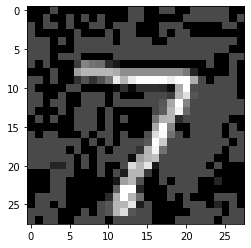

[[    0     1     2     3     4     5     6     7     8     9]
 [13720 15890 14448 14140 13748 12488 13412 14392 13636 14126]]


In [310]:
plt.imshow(fgsm_images_zico[10000], cmap='gray')
plt.show()

# show the first 1000 unique labels and counts
unique, counts = np.unique(fgsm_labels_zico, return_counts=True)
print(np.asarray((unique, counts)))

# take the first 10000 labels and images because higher epsilon values make the image unrecognizable
fgsm_images_zico = fgsm_images_zico[:10000]
fgsm_labels_zico = fgsm_labels_zico[:10000]

# squeeze fgsm_labels_zico and pgd_labels_zico to remove the extra dimension
fgsm_labels_zico = np.squeeze(fgsm_labels_zico)
pgd_labels_zico = np.squeeze(pgd_labels_zico)
spsa_labels_zico = np.squeeze(spsa_labels_zico)

In [311]:
# Test against PGD
prediction = trainer_2.predict(pgd_images_zico.astype(np.float32))
x_test_robust_pred = np.argmax(trainer_2.predict(pgd_images_zico), axis=1)
nb_correct_robust_pred = np.sum(x_test_robust_pred == pgd_labels_zico)

# print accuracy in percentage
print(np.sum(x_test_robust_pred == pgd_labels_zico) / len(pgd_labels_zico))

0.1135


In [246]:
# Test against FGSM
x_test_robust_pred = np.argmax(trainer_2.predict(fgsm_images_zico), axis=1)
nb_correct_robust_pred = np.sum(x_test_robust_pred == fgsm_labels_zico)

# print accuracy in percentage
print(np.sum(x_test_robust_pred == fgsm_labels_zico) / len(fgsm_labels_zico))

0.1135


In [247]:
# Test against SPSA
x_test_robust_pred = np.argmax(trainer_2.predict(spsa_images_zico), axis=1)
nb_correct_robust_pred = np.sum(x_test_robust_pred == spsa_labels_zico)

# print accuracy in percentage
print(np.sum(x_test_robust_pred == spsa_labels_zico) / len(spsa_labels_zico))

0.14


## Adversarial Training using AdversarialTrainerMadryPGD 

In [ ]:
trainer_3 = AdversarialTrainerMadryPGD(KerasClassifier(model_clean), nb_epochs=83, eps=0.3,eps_step=0.001)
trainer_3.fit(x_train.astype(np.float32), y_train)

Precompute adv samples:   0%|          | 0/1 [00:00<?, ?it/s]

Adversarial training epochs:   0%|          | 0/83 [00:00<?, ?it/s]

In [322]:
trainer_3_classifier = trainer_3.get_classifier()

In [324]:
x_test_robust_pred = np.argmax(trainer_3_classifier.predict(x_test.astype(np.float32)), axis=1)
nb_correct_robust_pred = np.sum(x_test_robust_pred == y_test)
        
print("Original test data: {}".format(y_test.shape[0]))
print("Correctly classified: {}".format(nb_correct_robust_pred))
print("Incorrectly classified: {}".format(y_test.shape[0] - nb_correct_robust_pred))
print("Accuracy percentage: {}".format(nb_correct_robust_pred / y_test.shape[0]))

Original test data: 10000
Correctly classified: 9837
Incorrectly classified: 163
Accuracy percentage: 0.9837


In [325]:
# Test against PGD
x_test_robust_pred = np.argmax(trainer_3_classifier.predict(pgd_images_zico), axis=1)
nb_correct_robust_pred = np.sum(x_test_robust_pred == pgd_labels_zico)

# print accuracy in percentage
print(np.sum(x_test_robust_pred == pgd_labels_zico) / len(pgd_labels_zico))

0.1135


In [326]:
# Test against FGSM
x_test_robust_pred = np.argmax(trainer_3_classifier.predict(fgsm_images_zico), axis=1)
nb_correct_robust_pred = np.sum(x_test_robust_pred == fgsm_labels_zico)

# print accuracy in percentage
print(np.sum(x_test_robust_pred == fgsm_labels_zico) / len(fgsm_labels_zico))

0.1135


In [327]:
# Test against SPSA
x_test_robust_pred = np.argmax(trainer_3_classifier.predict(spsa_images_zico), axis=1)
nb_correct_robust_pred = np.sum(x_test_robust_pred == spsa_labels_zico)

# print accuracy in percentage
print(np.sum(x_test_robust_pred == spsa_labels_zico) / len(spsa_labels_zico))

0.14


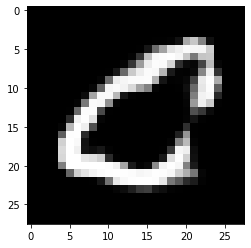

(94372, 28, 28, 1)
(94372,)


In [79]:
import numpy as np 
import matplotlib.pyplot as plt

# load mnist_adv dataset
# adv_path = 'assets/data/mnist_adv/'
adv_path = 'mnist_zico_defense_by_attack_with_z0/'
adv_files = []
X_adv = []
y_adv = []

# for loop to load all the images
for source in range(10):
    for target in range(10):
        if(source != target):
            file = np.load(adv_path + 'from' + str(source) + 'to' + str(target) + '.npz')
            adv_files.append(file)
            y_adv.extend(np.full(len(file['adv_imgs']), source).tolist())

keys = adv_files[0].files

for file in adv_files:
    with file as data:
        X_adv.extend(data[keys[0]])

X_adv = np.array(X_adv)
y_adv = np.array(y_adv)
y_one_hot = np.take(np.eye(10), y_adv, axis=0)

plt.imshow(X_adv[0], cmap='gray')
plt.show()
print(X_adv.shape)
print(y_adv.shape)

In [80]:
# Test against X_adv
x_test_robust_pred = np.argmax(trainer_2.predict(X_adv), axis=1)
nb_correct_robust_pred = np.sum(x_test_robust_pred == np.argmax(y_adv))

# print accuracy in percentage
print(np.sum(x_test_robust_pred == y_adv) / len(y_adv))

0.9201881914127071


## Perofrming SPSA on Madry's Model

In [108]:
!pip install cleverhans==3.1.0

     |████████████████████████████████| 320 kB 12.0 MB/s eta 0:00:01
  Attempting uninstall: cleverhans
    Found existing installation: cleverhans 4.0.0
    Uninstalling cleverhans-4.0.0:
      Successfully uninstalled cleverhans-4.0.0
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [18]:
from cleverhans.tf2.attacks.spsa import spsa
import tensorflow.compat.v1 as tf

tf.disable_v2_behavior()

#The attack requires the model to ouput the logits
logits_model = tf.keras.Model(model.input,model.layers[-1].output)

Instructions for updating:
non-resource variables are not supported in the long term


In [19]:
# load mnist
mnist = tf.keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

train_images = train_images / 255.0
test_images = test_images / 255.0

num_classes = 10

In [13]:
x_0 = tf.convert_to_tensor(np.array([train_images[0]]), dtype='float32')
y_0 = tf.convert_to_tensor(np.array(train_labels[0]), dtype='float32')

In [16]:
x_0.get_shape()

TensorShape([1, 28, 28])

In [20]:
# perform spsa on train_images
attack = spsa(logits_model, x = x_0, y = y_0, eps = 0.3, nb_iter = 10, clip_min=0.0, clip_max=1.0)

Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.while_loop(c, b, vars, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.while_loop(c, b, vars))


In [21]:
adv_x = tf.stop_gradient(attack)

In [22]:
preds_adv = model(adv_x)
print("Predicted Label: ", tf.keras.backend.get_value(tf.argmax(preds_adv, axis=-1))[0])
print("Correct Label: ", tf.keras.backend.get_value(y_0))

Predicted Label:  5
Correct Label:  5.0


In [44]:
preds_adv_madry = model_madry(adv_x)
print("Predicted Label: ", tf.keras.backend.get_value(tf.argmax(preds_adv_madry, axis=-1))[0])
print("Correct Label: ", tf.keras.backend.get_value(y_0))

Predicted Label:  3
Correct Label:  5.0


In [24]:
adv_x_image = tf.keras.backend.get_value(adv_x)
adv_x_image = np.reshape(adv_x_image, (28, 28, 1))

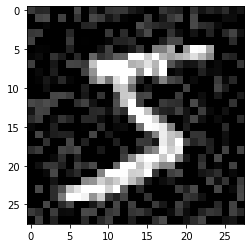

5.0

In [25]:
plt.imshow(adv_x_image, cmap='gray')
plt.show()
tf.keras.backend.get_value(y_0)

## Perofrming SPSA on model_adv 

In [62]:
# load model_adv
model_adv = tf.keras.models.load_model('mnist_adv_model.h5')

In [27]:
preds_adv_2 = model_adv(adv_x)

In [28]:
tf.keras.backend.get_value(tf.argmax(preds_adv_2, axis=-1))[0]

3

In [29]:
test_images.shape

(10000, 28, 28)

In [32]:
test_images_gen = test_images[:100]
test_labels_gen = test_labels[:100]
unique, counts = np.unique(test_labels_gen, return_counts=True)
print(np.asarray((unique, counts)))

[[ 0  1  2  3  4  5  6  7  8  9]
 [ 8 14  8 11 14  7 10 15  2 11]]


In [33]:
test_images_gen.shape

(100, 28, 28)

In [ ]:
type(test_labels[0])

## Generate Large Scale Adversarial Examples using SPSA

In [76]:
# calculate error rate for FGSM attack on both clean and adv model with varying epsilon values

# iterate from 0.1 to 1.5 with 0.1 step size
epsilon_values = np.arange(0.1, 0.4, 0.1)
spsa_images = []
spsa_labels = []

print(test_images_gen.shape)

for index, epsilon in enumerate(epsilon_values):
    print(epsilon)

    # original image and original label

    for i in range(test_images_gen.shape[0]): 
        original_image = test_images_gen[i]
        original_image = tf.convert_to_tensor(original_image.reshape((1,28,28)), dtype='float32') #The .reshape just gives it the proper form to input into the model, a batch of 1 a.k.a a tensor

        original_label = test_labels_gen[i]
        original_label = np.reshape(original_label, (1,)).astype('float32') # Give label proper shape and type for cleverhans

        
        # perform spsa on train_images
        adv_example = spsa(logits_model, x = original_image, y = original_label, eps = epsilon, nb_iter = 10, clip_min=0.0, clip_max=1.0)
        adv_example = tf.keras.backend.get_value(adv_example)
        
        # add fgsm image to list
        spsa_images.append(adv_example)
        spsa_labels.append(original_label)

np.savez('spsa_images_zico', images=spsa_images, labels=spsa_labels)

(100, 28, 28)
0.1
0.0 %
0.2
0.0 %
0.30000000000000004
0.0 %
0.4
0.0 %


In [77]:
spsa_labels = np.array(spsa_labels)
spsa_images = np.array(spsa_images)

spsa_images = np.reshape(spsa_images, (-1, 28, 28, 1))
spsa_labels = np.squeeze(spsa_labels)

In [78]:
spsa_images.shape

(400, 28, 28, 1)

In [79]:
spsa_labels.shape

(400,)

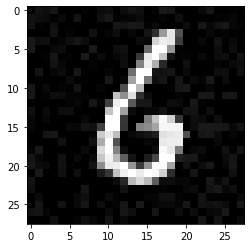

6.0


In [81]:
plt.imshow(spsa_images[50], cmap='gray')
plt.show()
print(spsa_labels[50])

In [46]:
# Test against X_adv
x_test_robust_pred = np.argmax(model_madry.predict(spsa_images_zico), axis=1)
nb_correct_robust_pred = np.sum(x_test_robust_pred == np.argmax(spsa_labels_zico))

# print accuracy in percentage
print(np.sum(x_test_robust_pred == spsa_labels_zico) / len(spsa_labels_zico))

45.47


In [85]:
# Test against X_adv
x_test_robust_pred = np.argmax(model_adv.predict(spsa_images), axis=1)
nb_correct_robust_pred = np.sum(x_test_robust_pred == np.argmax(spsa_labels))

# print accuracy in percentage
print(np.sum(x_test_robust_pred == spsa_labels) / len(spsa_labels))

0.965
